# Machine Learning Project
SMIA 2024, project on "Neural Dimensionality reduction"

> ##### Author: Neri Lorenzo
> ##### Badge number: 2088285

# Neural Dimensionality reduction

The goal of this project is to perform dimensionality reduction using a small neural network on a
simple dataset (e.g. MNIST) and then compare the learnt embedding space to the one learnt by
PCA or t-SNE.

- Here's the idea: we can create a neural network that takes a n-dimensional element, encodes it in a 2-dimensional vector (needed to plot the embedding) and restores it into a n-dimensional element (as similar as possible to the input object).
- This way we will know if the vector associated at the input is the right one or not.
- The model just described is called Autoencoder (AE)

## Autoencoder

- For this task, we are going to build an autoencoder with 784-dimensional input and output, and 2-dimensional latent space

### Import dependencies

- First we need to import the necessary libraries; we'll use Tensorflow for the model and the dataset

In [1]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt

# To create our NN we will use tensorflow (keras), using pytorch is equivalent
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization

# MNIST is the dataset on witch we'll perform the task (n = 28x28 = 784)
from tensorflow.keras.datasets import mnist
from skimage import metrics

# Later on we will compare the embedding learnt with these tecniques
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Data loading

- Next up we have to load our training and testing data, we will use the MNIST ( (28x28) images )
- As always, we'll do cross validation, dividing in training set and testing set, as well as normalizing the data
- To gain more generalization we're going to randomize the sets


In [2]:
# Load the MNIST dataset
(x_train, train_labels), (x_test, test_labels) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Randomize both the training and test
permutation = np.random.permutation(len(x_train))
x_train, train_labels = x_train[permutation], train_labels[permutation]
permutation = np.random.permutation(len(x_test))
x_test, test_labels = x_test[permutation], test_labels[permutation]

list_xtest = [ [x_test[i], test_labels[i]] for i in test_labels]
print(len(list_xtest))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
10000


### Model architecture

- Now we need to define the structure of our autoencoder.
- There are a lot of possible structures but they all have to have two things in common: 2-dimensional latent space and 784-dimensional input and output.
- I was struggling to find the best configuration of layers: to avoid overfitting i tried a little number of hidden layers, like 3 or 5, but the loss wouldnt go down as i wanted. When i tried adding layers i had better results.
- For this reason our structure choice is a 7 hidden layer configuration that looks like this: ```784 - 256 - 128 - 64 - 2 - 64 - 128 - 256 - 784```.
- In "function terms" we will have our MLP defined as $ g_{\theta} = f_{\theta_1} \circ (\sigma \circ f_{\theta_2}) \circ (\sigma \circ f_{\theta_3}) \circ (\sigma \circ f_{\theta_4}) \circ (\sigma \circ f_{\theta_5}) \circ (\sigma \circ f_{\theta_6}) \circ (\sigma \circ f_{\theta_7}) \circ (\sigma' \circ f_{\theta_8})$
with:
 - $ f_{\theta_1}:\mathbb{R}^{784} \to \mathbb{R}^{256} $
 - $ f_{\theta_2}:\mathbb{R}^{256} \to \mathbb{R}^{128} $
 - $ f_{\theta_3}:\mathbb{R}^{128} \to \mathbb{R}^{64} $
 - $ f_{\theta_4}:\mathbb{R}^{64} \to \mathbb{R}^{2} $
 - $ f_{\theta_5}:\mathbb{R}^{2} \to \mathbb{R}^{64} $
 - $ f_{\theta_6}:\mathbb{R}^{64} \to \mathbb{R}^{128} $
 - $ f_{\theta_7}:\mathbb{R}^{128} \to \mathbb{R}^{256} $
 - $ f_{\theta_8}:\mathbb{R}^{256} \to \mathbb{R}^{784} $
 - $ \sigma,\sigma' $ activation functions
- Since we need the two-dimensional compressed images, it's easier to build two models: build the Encoder and Decoder, combine them, train the merged model and then evaluate only the first one to get the compressed images, aka latent representations.









#### Define the Encoder:
- The encoder will compress the input into the two-dimensional latent space.
- The $\text{ReLU}$ (Rectified Linear Unit) activation function, defined as $\text{ReLU}(x) = max(0,x) $, is chosen for its **simplicity** and **computational efficiency** ( resulting in $\sigma = \text{ReLU} $ in the original MLP formula ).


In [3]:
encoder_input = Input(shape=(784,))
encoded = Dense(512, activation='relu')(encoder_input)
encoded = BatchNormalization()(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(2, activation='relu')(encoded)
encoder1 = Model(encoder_input, encoded)

#### Define the Decoder:
- The decoder will reconstruct the input from the latent space.
- This is basically the encoder flipped, but with the twist of the $\text{SIGMOID}$ activation function, defined as $\text{SIGMOID}(x) = \frac{1}{1 + e^{-x}} $, in the **output layer** because every pixel of the output image must be between 0 and 1 ( resulting in $\sigma' = \text{SIGMOID} $ in the original MLP formula ).

In [4]:
decoder_input = Input(shape=(2,))
decoded = Dense(64, activation='relu')(decoder_input)
decoded = BatchNormalization()(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
decoder1 = Model(decoder_input, decoded)

#### Build and Compile the Autoencoder:

- Combine the encoder and decoder into an autoencoder model.

In [5]:
# Create the autoencoder
autoencoder1 = Model(encoder_input, decoder1(encoder1(encoder_input)))

### Model training



- Before training we obviously have to choose learning rate, the optimizer (like adam, gradient descent, stochastic gradient descent...) and the type of loss (or ojective function) we're minimizing.
- Our optimizer choice is Adam (Adaptive Momentum Estimate) witch combines adaptive learning rate methods and momentum methods, leading to faster and more reliable convergence, with minimal need for hyperparameter adjustment.
- We'll use Mean Squared Error as the objective function defined as:
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - g_\theta(x_i))^2$$
with $g_\theta$ the neural network and $\theta$ the parameters.

In [6]:
decay = 0.80
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-01,
    decay_steps           = 2500,
    decay_rate            = decay,
    staircase             = True
                                                                    )

tensorflow.keras.optimizers.Adam(learning_rate = lr_schedule,
                                        beta_1 = 0.95,
                                        beta_2 = 0.99,
                                       epsilon = 1e-01
                                 )

autoencoder1.compile(optimizer='adam', loss='mean_squared_error')

- Now all we need to do is just train (estimated time: 8 minutes).
 - Note that we are giving x_train as input to the model and x_train as expected output, but not y_train because this is an autoencoder, not a classifier, so in the $ \text{MSE} $ formula $ y_i $ is $ x_i $.

In [7]:
history1 = autoencoder1.fit(x_train, x_train,
                epochs=25,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - loss: 0.1637 - val_loss: 0.0684
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.0609 - val_loss: 0.0605
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.0532 - val_loss: 0.0550
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 0.0553 - val_loss: 0.0540
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.0522 - val_loss: 0.0494
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 0.0513 - val_loss: 0.0487
Epoch 7/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.0474 - val_loss: 0.0460
Epoch 8/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0428 - val_loss: 0.0428
Epoch 9/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.0417 - val_loss: 0.0429
Epoch 10/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - loss: 0.0410 - val_loss: 0.0433
Epoch 11/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - loss: 0.0412 - val_loss: 0.0412
Epoch 12/25
118/118

- Using MSE as loss and Adam as optimizer is unusual for AE's.
- If we're not satisfied with the results, we can use the NLL in combination with the KL divergence (we'll catch up to that later on).

### Check loss decrease

- Now, as useful as it can be considered, we can visualize the values of the training loss and the validation loss wrt the epochs.

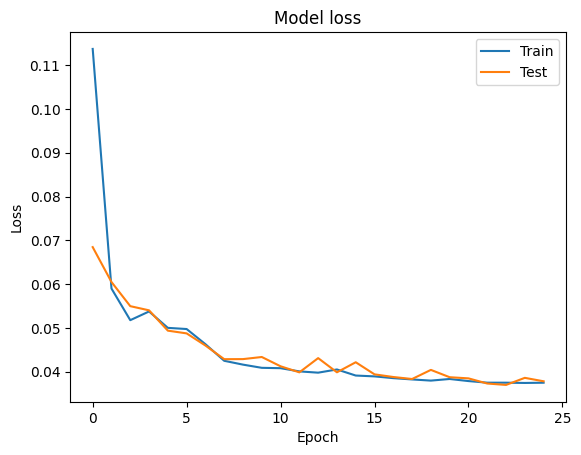

In [8]:
# Plot the training history
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

- No sign of overfitting... good!😁

### Check if the AE is working properly

- Before trying to visualize the embedded data, we need to verify if our model is actually well reconstructing the images so we know if it'll generate a good embedding... right?

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
[2, 5, 3, 8, 2, 0, 1, 3, 3, 8]


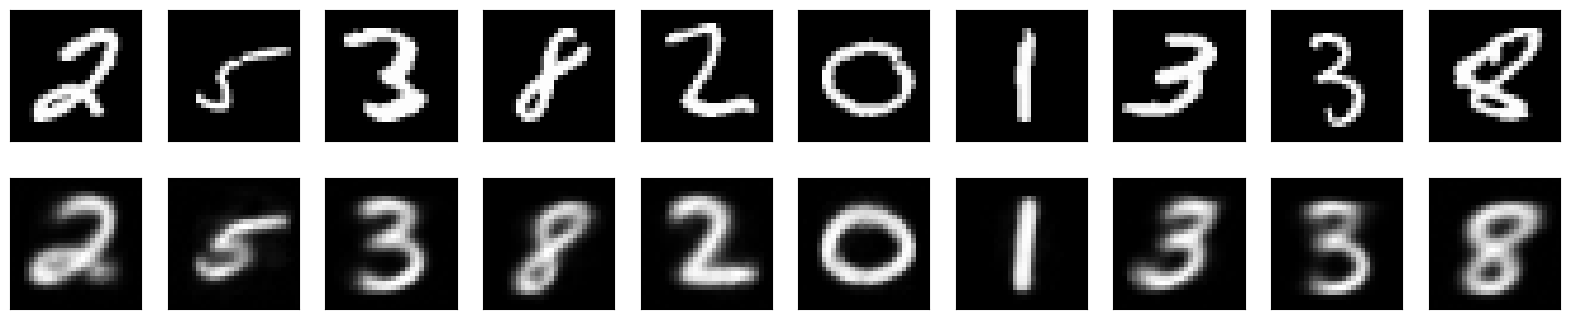

In [9]:
# Plot the test figures vs. predicted figures
decoded_imgs = autoencoder1.predict(x_test)

import random
indexes = [random.randint(0, 999) for _ in range(10)]
n = 10
list_xtestn = [ [x_test[i], test_labels[i]] for i in indexes]
print([list_xtestn[i][1] for i in range(n)])
plt.figure(figsize=(20, 4))
j = 0
for i in indexes:
    # Display original
    ax = plt.subplot(2, n, j + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, j + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j+=1

plt.show()

- It could be better, but it could be mutch worse...
- We can see that some numbers are mis-reconstructed (if not: re-run, i'm sure you will find them).
- Lets hope that the embedding is somewhat good🤞.

### Embedding

- Finally, for every image of the validation set, we extract the latent representation and plot it, generating an embedding for the images considered.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


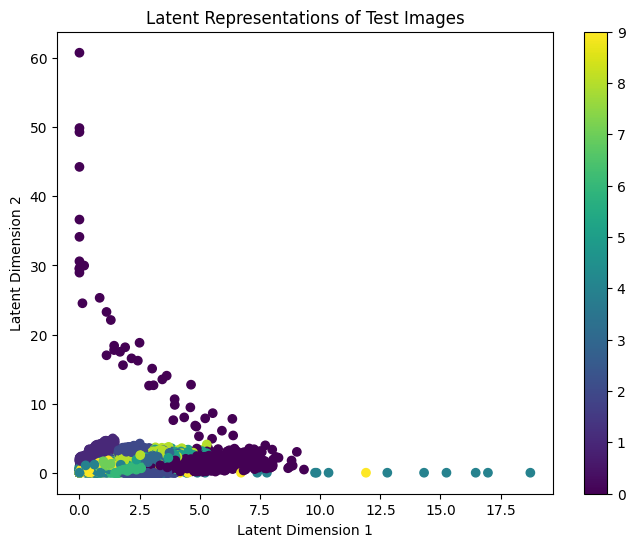

In [10]:
# Encode the test images
latent_representations = encoder1.predict(x_test)

# Plot the latent representations
plt.figure(figsize=(8, 6))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=test_labels, cmap='viridis')
plt.colorbar()
plt.title("Latent Representations of Test Images")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

- Preatty bad right? after all this work...🥲
- To put a good word for the model, it is clear that some classess are well defined and separated from the other ones.
- As previously mentioned, since we didn't obtain the wanted results, we are going to use the Negative Log-Likelihood (NLL) and the Kullback-Leibler divergence $ D_{kl} $.
- Using a probabilistic approach makes our Autoencoder a Variational Autoencoder (VAE)

## Variational Autoencoder




(inspiration took from [here](https://fnallpc.github.io/machine-learning-hats/notebooks/5-vae-mnist.html#overview))


- Our VAE will have Gaussian Latent variables and a Gaussian Posterior distribution $q_\phi({\mathbf z}|{\mathbf x})$ with a diagonal covariance matrix.

- Our four essential elements are:

 - A latent variable ${\mathbf z}$ drawn from a distribution $p({\mathbf z})$ which in our case will be $\mathcal{N}(0,\epsilon^2)$.
 - A decoder $p(\mathbf{x}|\mathbf{z})$ that maps latent variables ${\mathbf z}$ to visible variables ${\mathbf x}$.
 - An encoder $q_\phi(\mathbf{z}|\mathbf{x})$ that maps examples to the latent space. In our case, this map is: $q_\phi({\bf z}|{\bf x})= \mathcal{N}({\bf z}, \boldsymbol{\mu}({\bf x}), \mathrm{diag}(\boldsymbol{\sigma}^2({\bf x})))$, so a Gaussian with means and variances that depend on the input
 - A cost function consists in two terms:
   - The reconstruction error
   - An additional regularization term that minimizes the KL-divergence between the variational and true encoders.

    The reconstruction error is just the cross-entropy between the samples and their reconstructions. The KL-divergence term can be calculated analytically for this term and can be written as

$$-D_{KL}(q_\phi({\bf z}|{\bf x})|p({\bf z}))={1 \over 2} \sum_{j=1}^J \left (1+\log{\sigma_j^2({\bf x})}-\mu_j^2({\bf x}) -\sigma_j^2({\bf x})\right).
$$
- now that we got this out of the way it's time to implement it!

### Import dependencies

- Let's import the missing libraries.

In [11]:
from scipy.stats import norm

from tensorflow.keras import backend as K

from tensorflow.keras.layers import InputLayer, Lambda, Add, Multiply
from tensorflow.keras.models import Sequential
import tensorflow.compat.v1 as tf
import pandas as pd

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

### Model architecture

- Our new neural network si going to look like this: ``` 784 - 256 - 2 - 256 - 784 ```.
- In the following code we specify the hyperparameters needed.



In [12]:
# Specify hyperparameters
original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 256
epochs = 10
epsilon_std = 1.0 # this is the standard deviation of the distribution of the latent variable

#### The loss

- As mentioned, here we define the objective function to minimize during training.

In [13]:
class KLDivergenceLayer(Layer):
    """Identity transform layer that adds KL divergence to the final model loss."""

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch))
        return inputs

# Negative Log Likelihood Loss Function
def nll(y_true, y_pred):
    """Negative log likelihood loss for Gaussian distributed outputs."""
    return 0.5 * K.sum(K.square(y_true - y_pred), axis=-1)

- Now it is time to actually build and compile the model in the same way as we did for the previous model for the exception of some changes.


#### Encoder

- The changes here are **lambda layers**: they basically are layers that allow you to apply custom operations to the data as it passes through using a simple function.

In [14]:
input_encoder_layer  = Input(shape=(original_dim,))
hidden_encoder_layer = Dense(intermediate_dim, activation='relu')(input_encoder_layer)
z_mu                 = Dense(latent_dim)(hidden_encoder_layer)
z_log_var            = Dense(latent_dim)(hidden_encoder_layer)

# Use the KLDivergenceLayer to add KL divergence loss
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

# Reparameterization trick using Lambda layers
def sampling(args):
    z_mu, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim))
    return z_mu + K.exp(0.5 * z_log_var) * epsilon

# Use Lambda layer to apply the sampling function
z = Lambda(sampling)([z_mu, z_log_var])

# Define the encoder model
encoder2 = Model(inputs=input_encoder_layer, outputs=z)

#### Decoder

In [15]:
# Define the decoder as a Sequential MLP model
decoder2 = Sequential(
    [
     Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
     Dense(original_dim, activation='sigmoid'),
    ]
                     )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- Now it's time for us to compile the model with the NLL loss and the optimizer RMSprop.
- $\text{RMSprop}$, short for Root Mean Square Propagation, is an optimization algorithm that adjusts the learning rate for each parameter based on the magnitude of recent gradients for that parameter and brings improvements on training performance and stability.

In [16]:
# Reconstruct the input
x_pred = decoder2(z)

# Define the VAE model
vae = Model(inputs=input_encoder_layer, outputs=x_pred)

# Compile the VAE model using NLL as the loss
vae.compile(optimizer='rmsprop', loss=nll)

### Model training

- Now the boring part 😴 (estimated time: 6 minutes).
- [here](https://www.youtube.com/watch?v=cEhOgmkk0zE) some music while you wait.

In [17]:

# Load and preprocess the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim).astype('float32') / 255
x_test = x_test.reshape(-1, original_dim).astype('float32') / 255

# Train the VAE model
history2 = vae.fit(x_train,
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - loss: 40.0654 - val_loss: 24.2776
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - loss: 24.0251 - val_loss: 23.3976
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - loss: 23.4006 - val_loss: 22.9974
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 22.9881 - val_loss: 22.7810
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - loss: 22.8192 - val_loss: 22.6551
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - loss: 22.7016 - val_loss: 22.5581
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - loss: 22.5884 - val_loss: 22.3862
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - loss: 22.4537 - val_loss: 22.3370
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 22.3448 - val_loss: 22.3153
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 22.2702 - val_loss: 22.1805


### Loss decrease

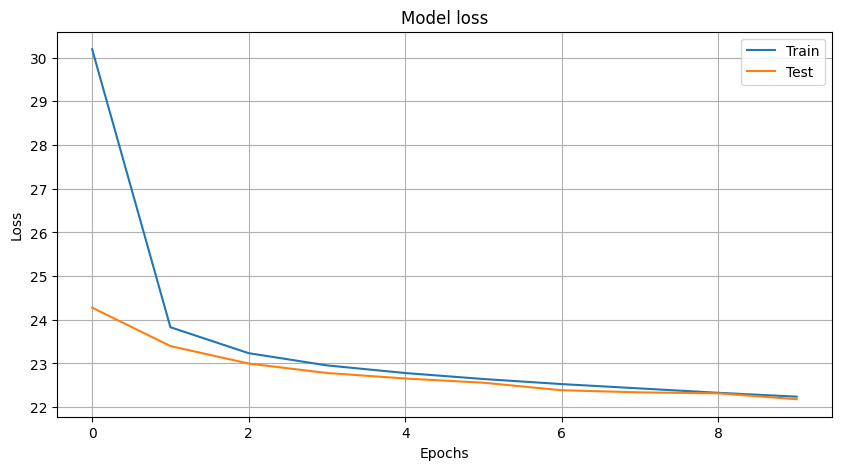

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid(True)
plt.show()

### Check if the VAE is working properly

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


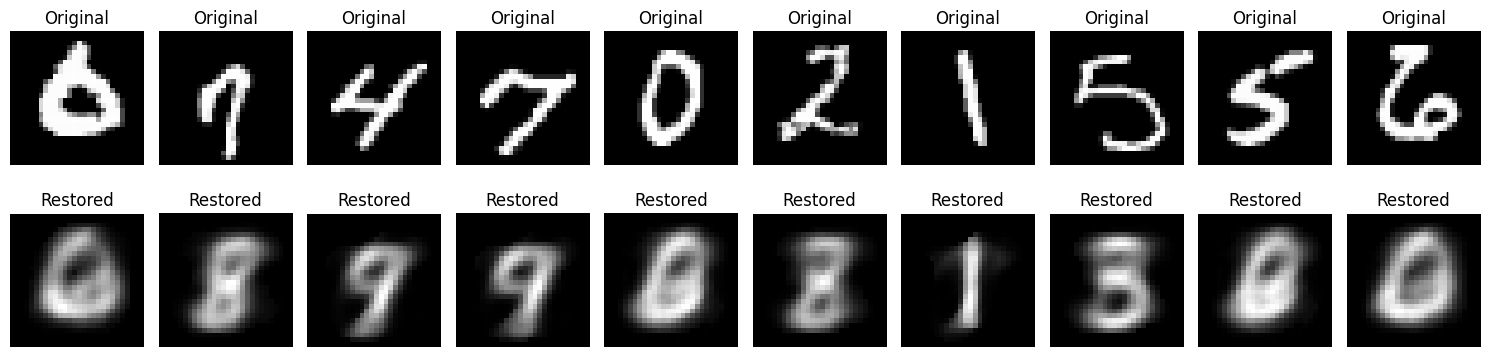

In [19]:
# Select ten random images from the test set
num_images = 10
indices = np.random.choice(len(x_test), num_images, replace=False)
x_test_sample = x_test[indices]

# Generate restored images using the VAE
x_restored = vae.predict(x_test_sample)

# Reshape images for plotting
x_test_sample = x_test_sample.reshape(num_images, 28, 28)
x_restored = x_restored.reshape(num_images, 28, 28)

# Plot the original and restored images
plt.figure(figsize=(15, 4))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_sample[i], cmap='gray')
    plt.axis('off')
    plt.title('Original')

    # Restored image
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(x_restored[i], cmap='gray')
    plt.axis('off')
    plt.title('Restored')

plt.tight_layout()
plt.show()

- The reconstruction quality is definitely worse than the previous, so we know that the classess won't be really well defined and separated.
- Our only hope is that the shift of approach will result in a better encoder, lets see...

### Embedding

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


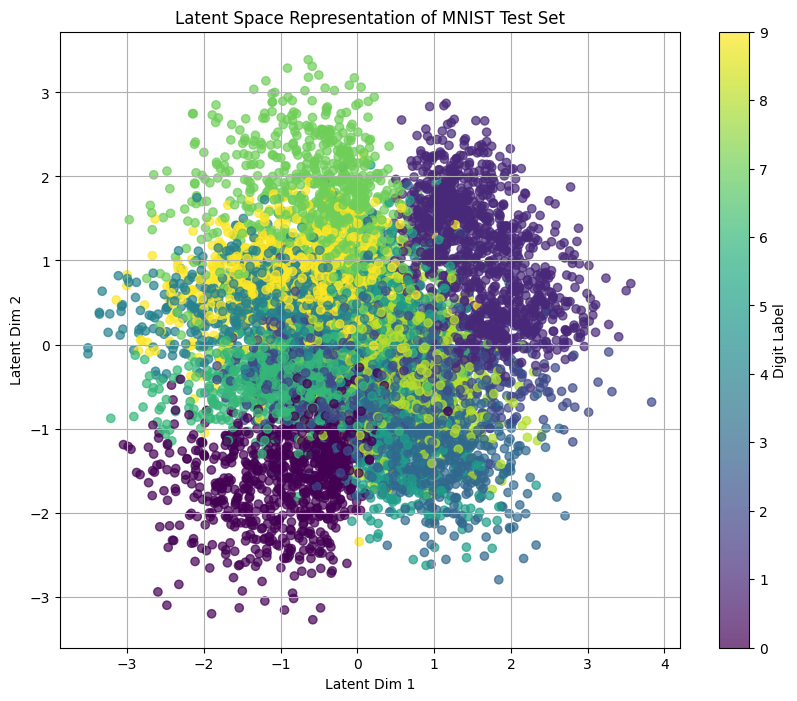

In [20]:
# Get the latent representations from the encoder
z_test = encoder2.predict(x_test)

# Plot the latent space representations
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title('Latent Space Representation of MNIST Test Set')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.grid(True)
plt.show()

- YES! finally got a decent one 🎉
- We did our task, but can we do more?
- This is a good way to use the encoder, but what about the decoder?

### Image generator


- One of the nice things about VAEs is that they are generative models. Thus, we can generate new examples in two different ways:
  - linear sampling
  - inverse CDF sampling



- linear sampling consists in sampling uniformally in the latent space.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


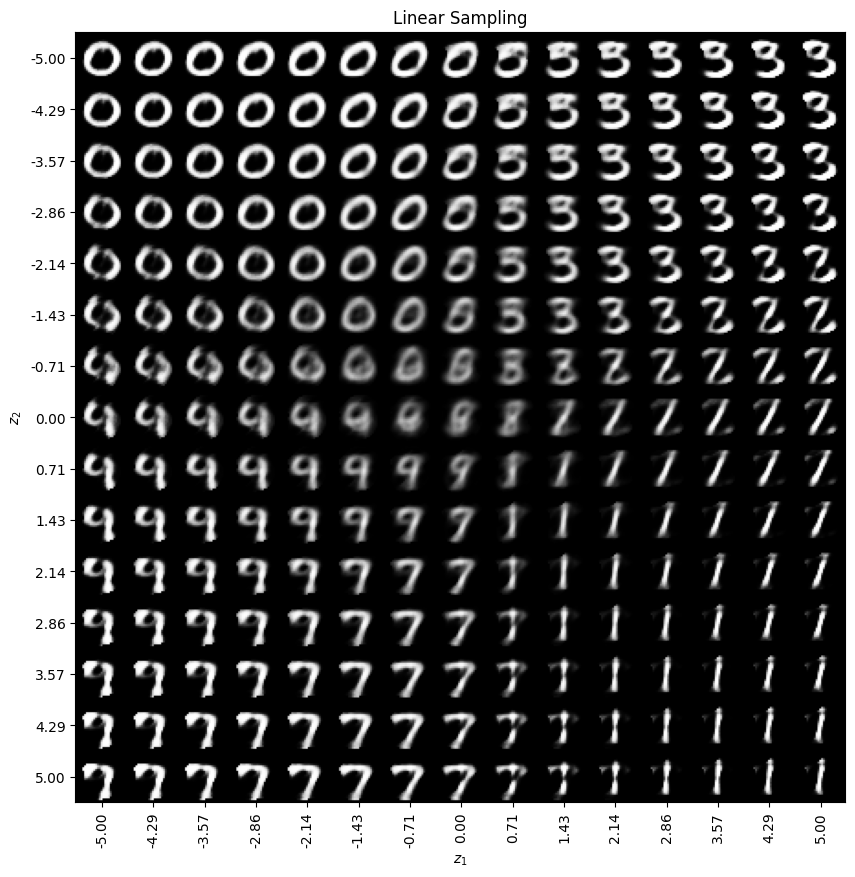

In [21]:
# Define dimensions and sampling parameters
n = 15  # Number of images along each axis of the grid
latent_dim = 2
img_rows, img_cols = 28, 28  # Image dimensions for MNIST

# Linear Sampling: generating n points between -5 and 5
# for the first and the second latent dimension
z1_u = np.linspace(-5, 5, n)
z2_u = np.linspace(-5, 5, n)
z_grid = np.dstack(np.meshgrid(z1_u, z2_u))

# Generate images using the decoder
x_pred_grid = decoder2.predict(z_grid.reshape(n * n, latent_dim)).reshape(n, n, img_rows, img_cols)

# Plot Linear Sampling
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.xticks(np.arange(0, n * img_rows, img_rows) + 0.5 * img_rows, ["{:.2f}".format(val) for val in z1_u], rotation=90)
plt.yticks(np.arange(0, n * img_cols, img_cols) + 0.5 * img_cols, ["{:.2f}".format(val) for val in z2_u])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.title("Linear Sampling")
plt.grid(False)
plt.show()

- The second way we can do that is sampling accounting for the fact that the latent space is Gaussian, so we expect most of the data points to be centered around (0,0) and fall off exponentially in all directions. This is done by transforming the uniform grid using the inverse Cumulative Distribution Function (CDF) for the Gaussian.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


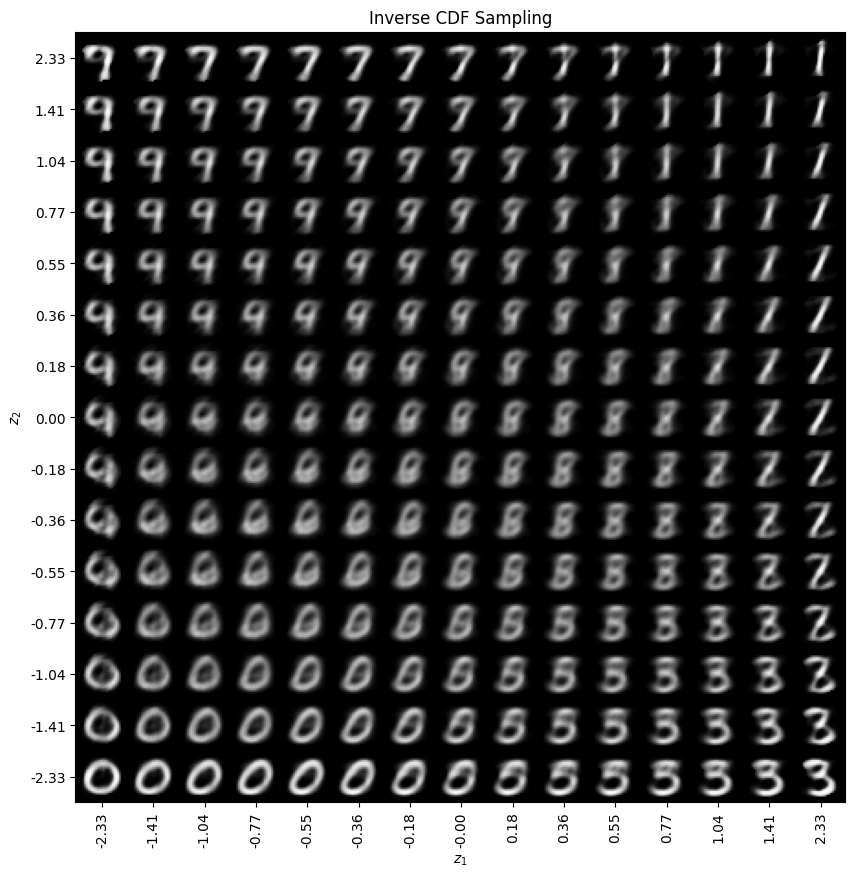

In [22]:
# Inverse CDF Sampling
quantile_min = 0.01
quantile_max = 0.99

z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid2 = np.dstack(np.meshgrid(z1, z2))

# Generate images using the decoder
x_pred_grid2 = decoder2.predict(z_grid2.reshape(n * n, latent_dim)).reshape(n, n, img_rows, img_cols)

# Plot Inverse CDF Sampling
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid2))), cmap='gray')
plt.xticks(np.arange(0, n * img_rows, img_rows) + 0.5 * img_rows, ["{:.2f}".format(val) for val in z1], rotation=90)
plt.yticks(np.arange(0, n * img_cols, img_cols) + 0.5 * img_cols, ["{:.2f}".format(val) for val in z2])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.title("Inverse CDF Sampling")
plt.grid(False)
plt.show()

## Comparisons

- Now that we got a nice embedding lets compare it with the ones done by PCA and tSNE in a subset of the test set.

In [23]:
# Reduce data size for quick visualization
n_samples = 5000
x_test_sampled = x_test[:n_samples]
y_test_sampled = y_test[:n_samples]

- Now we apply our dimensional scaling methods on the sampled data...

In [24]:
# Apply PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_test_sampled)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_test_sampled)

# Find the latent representations with
# the first encoder
latent_representations = encoder1.predict(x_test_sampled)

# Find the latent representations with
# the second encoder
x_test_encoded = encoder2.predict(x_test_sampled, batch_size=batch_size  )

  4/157 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


- ... And FINALLY the **comparison**.

<Figure size 1500x500 with 0 Axes>

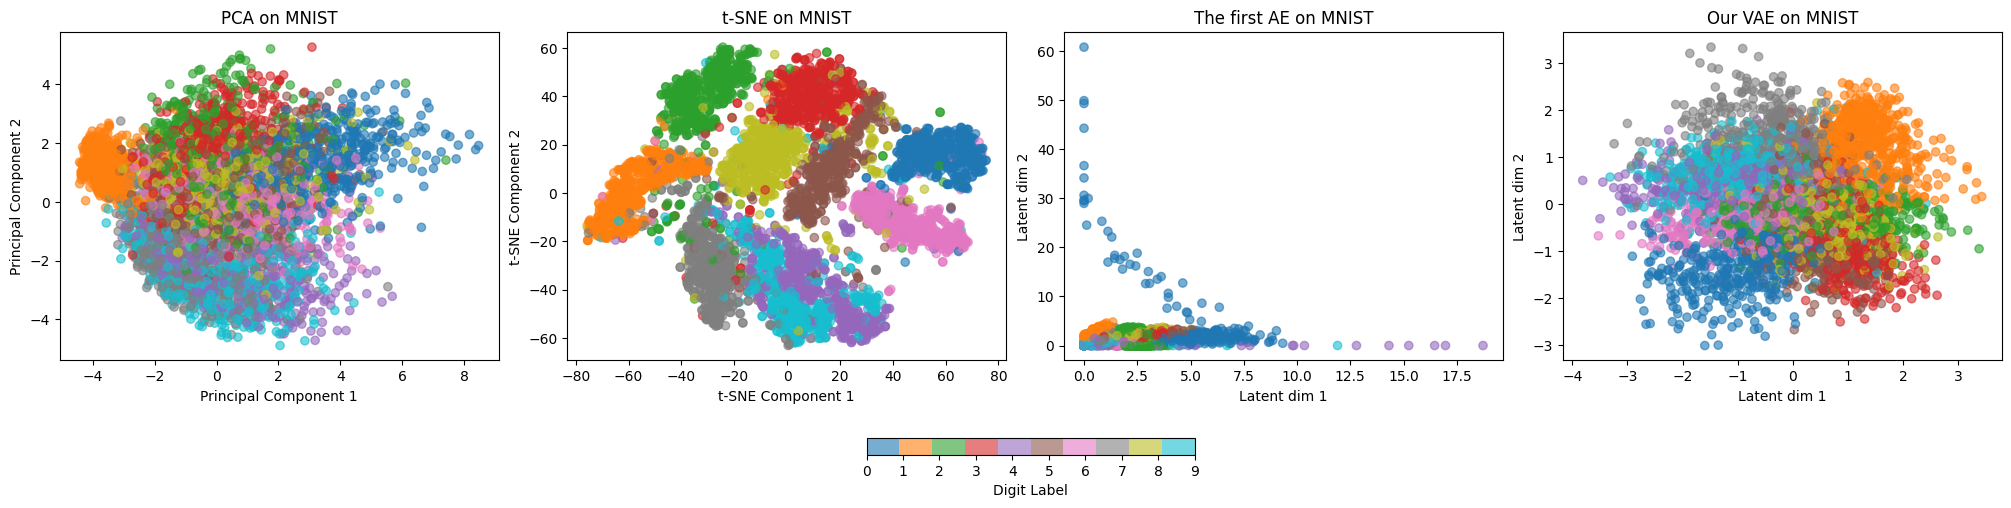

In [25]:
plt.figure(figsize=(15, 5))

# Set up the figure and the grid for the plots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

# Plot PCA results
scatter1 = axs[0].scatter(x_pca[:, 0], x_pca[:, 1], c=y_test_sampled, cmap='tab10', alpha=0.6)
axs[0].set_title('PCA on MNIST')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

# Plot t-SNE results
scatter2 = axs[1].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test_sampled, cmap='tab10', alpha=0.6)
axs[1].set_title('t-SNE on MNIST')
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('t-SNE Component 2')

# Plot the first AE results
scatter3 = axs[2].scatter(latent_representations[:, 0], latent_representations[:, 1], c=y_test_sampled, cmap='tab10', alpha=0.6)
axs[2].set_title('The first AE on MNIST')
axs[2].set_xlabel('Latent dim 1')
axs[2].set_ylabel('Latent dim 2')

# Plot VAE results
scatter4 = axs[3].scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_sampled, cmap="tab10", alpha=0.6)
axs[3].set_title('Our VAE on MNIST')
axs[3].set_xlabel('Latent dim 1')
axs[3].set_ylabel('Latent dim 2')

# Add a shared colorbar below the plots
cbar = fig.colorbar(scatter4, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_ticks(range(10))
cbar.set_label('Digit Label')

plt.show()


- After creating and training two neural networks to get **at best** a decent embedding, it is very clear now why t-SNE, or variations of it, is a **standard** method in dimensionality reduction.